In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import defaultdict
import calendar
from sklearn.metrics import mean_squared_error as mse

In [2]:
def dickey_fuller(X):
    dickey = adfuller(X)
    print('ADF Statistic: %f' % dickey[0])
    print('p-value: %f' % dickey[1])
    print('Critical Values:')
    for key, value in dickey[4].items():
        print('\t%s: %.3f' % (key, value))
    return 


# Cuba Land Temperature
- Date range: Jan 1823 - Sept 2013

In [3]:
data_path = 'D:/Time Series/data/'

In [4]:
cuba = pd.read_csv(data_path+'cuba_temperature.csv')
cuba = cuba[['dt','AverageTemperature']]
cuba['dt'] = pd.to_datetime(cuba['dt'])
cuba = cuba.set_index('dt')


In [5]:
len(cuba)

2289

In [6]:
cuba.head()

,AverageTemperature
dt,
1823-01-01,22.381
1823-02-01,21.031
1823-03-01,23.771
1823-04-01,24.232
1823-05-01,26.075


From the dataframe above, we know that the dataset used is recorded monthly, now we would like to predict five years of data, thus we would have to take out the last 60 data points and serve them as test set

In [7]:
split_idx = len(cuba) - 60
cuba_train = cuba[:split_idx]
cuba_test = cuba[split_idx:]
train_X, train_y = cuba_train.index, cuba_train['AverageTemperature']
test_X, test_y = cuba_test.index, cuba_test['AverageTemperature']

## Dataset analysis

C:\Users\user\.conda\envs\mimos\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


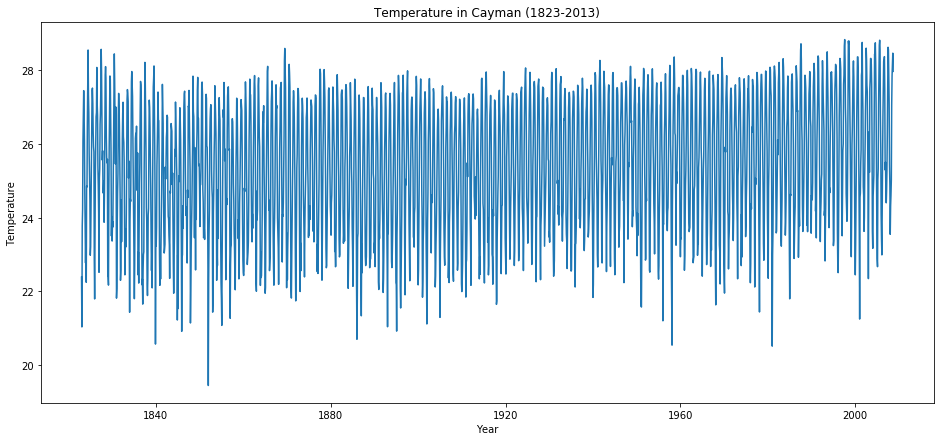

In [5]:
plt.figure(figsize=(16,7))
plt.plot(train_X,train_y)
plt.title('Temperature in Cayman (1823-2013)')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

### Stationarity test for original time series
1. The ACF plot below shows strong seasonality with 12 months period. A seasonality differencing is required.
2. The local maximas' values vary a little, which we can assume that the seasonality is not multiplicative. In case that the seasonality is multiplicative, we will have to log-transform it to make it additive so that the data can be differentiated until stationary.

ADF Statistic: -3.517826
p-value: 0.007541
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


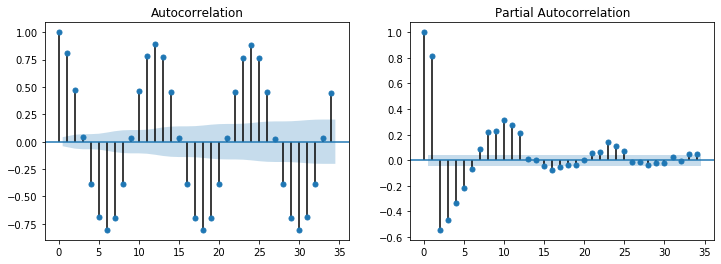

In [13]:
dickey_fuller(train_y)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(train_y, ax[0])
plot_pacf(train_y, ax[1])
plt.show()

### Apply twelve-period differencing
- Insights: 
   - the ACF plot shows sharp cut-off at lag-1 -> set Q=1
   - the PACF plot shows sharp cut-off at lag-1 -> set P=1
   - SARIMAX order to be used: (0,0,0)(1,1,1,12)

ADF Statistic: -14.722863
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


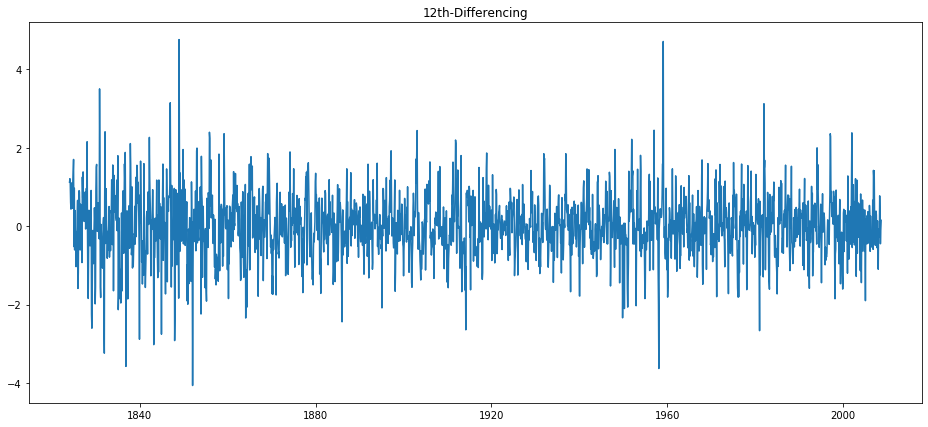

In [14]:
period = 12
diff_df = cuba_train.diff(periods=period,axis=0)
diff_df_y = diff_df['AverageTemperature'].values[period:]
dickey_fuller(diff_df_y)
plt.figure(figsize=(16,7))
plt.title('12th-Differencing')
plt.plot(train_X[period:],diff_df_y)

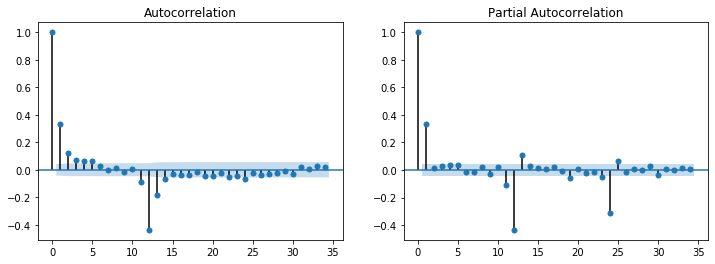

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(diff_df_y, ax[0])
plot_pacf(diff_df_y, ax[1])
plt.show()

## Models fitting

### 1. SARIMAX (0,0,0)(1,1,1,12)
- Result analysis: 
  - The ACF plot shows decaying pattern which indicates the time series is underdifferenced, thus set d=1 for the next model


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                            Statespace Model Results                            
Dep. Variable:       AverageTemperature   No. Observations:                 2229
Model:             SARIMAX(1, 1, 1, 12)   Log Likelihood               -2101.676
Date:                  Sun, 12 Jul 2020   AIC                           4209.351
Time:                          12:48:08   BIC                           4226.463
Sample:                      01-01-1823   HQIC                          4215.602
                           - 09-01-2008                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0784      0.018      4.398      0.000       0.043       0.113
ma.S.L12      -0.9155      0.009    -98.005      0.000      -0.934      -0.897
sigma2         0.3863      0.008    

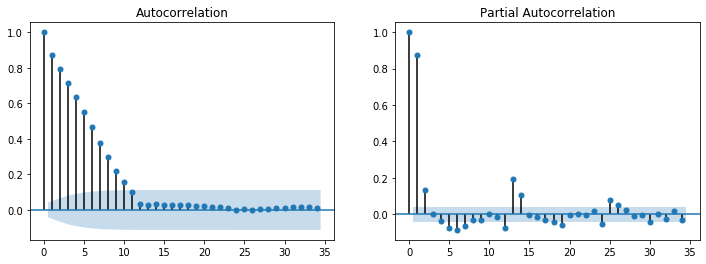

In [8]:
sarima000111 = SARIMAX(train_y, order=(0,0,0), seasonal_order=(1,1,1,12)).fit()
print(sarima000111.summary())
sarima000111_res = pd.DataFrame(sarima000111.resid)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(sarima000111_res, ax[0])
plot_pacf(sarima000111_res, ax[1])
plt.show()

In [9]:
sarima000111_prediction = sarima000111.get_forecast(len(test_X))
pred = sarima000111_prediction.predicted_mean
ci = sarima000111_prediction.conf_int().values
lower_ci = [item[0] for item in ci]
upper_ci = [item[1] for item in ci] 

In [10]:
# rmse
rmse = np.sqrt(mse(test_y, pred))
print('rmse: ', rmse)

rmse:  0.7412611021343689


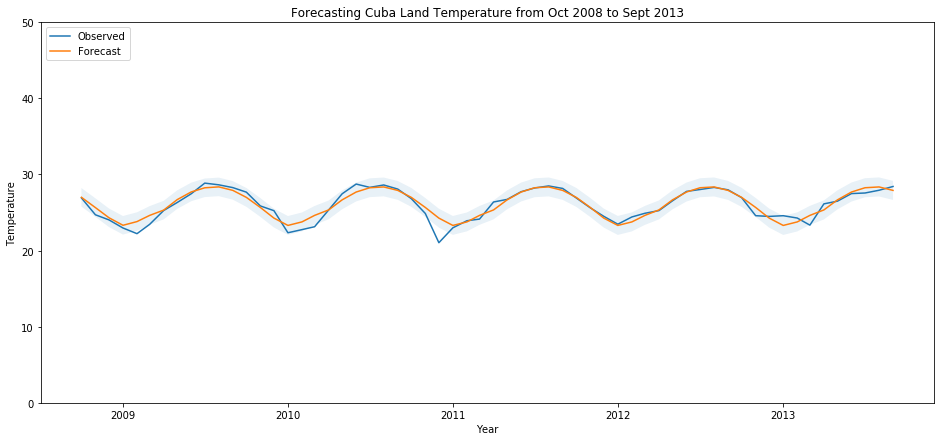

In [37]:
plt.figure(figsize=(16,7))
plt.plot(test_X, test_y, label='Observed')
# plt.plot(np.concatenate((train_X,test_X)), gtruth_masked, label='Ground-truth', color='green')
plt.plot(test_X, pred, label='Forecast')
plt.fill_between(x=test_X, y1=upper_ci, y2=lower_ci, alpha=.1)
plt.legend(loc='upper left')
plt.title('Forecasting Cuba Land Temperature from Oct 2008 to Sept 2013')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.ylim([0,50])
plt.show()

### 2. SARIMAX (0,1,0)(1,1,1,12)
- Both ACF and PACF plots have sharp cut-off at lag 1, the model doesn't fit the data well, thus set p=1, q=1 for the next model

C:\Users\user\.conda\envs\mimos\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\.conda\envs\mimos\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                 2229
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2341.256
Date:                              Tue, 07 Jul 2020   AIC                           4688.511
Time:                                      00:32:07   BIC                           4705.621
Sample:                                  01-01-1823   HQIC                          4694.761
                                       - 09-01-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0649      0.016      3.971      0.000       0.033       0.097
ma.S.L12      -0.98

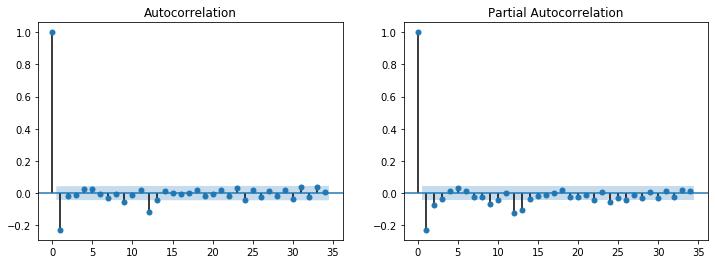

In [30]:
sarima010111 = SARIMAX(train_y, order=(0,1,0), seasonal_order=(1,1,1,12)).fit()
print(sarima010111.summary())
sarima010111_res = pd.DataFrame(sarima010111.resid)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(sarima010111_res, ax[0])
plot_pacf(sarima010111_res, ax[1])
plt.show()

In [31]:
sarima010111_prediction = sarima010111.get_forecast(len(test_X))
pred = sarima010111_prediction.predicted_mean
ci = sarima010111_prediction.conf_int().values
lower_ci = [item[0] for item in ci]
upper_ci = [item[1] for item in ci] 

In [32]:
# rmse
rmse = np.sqrt(mse(test_y, pred))
print('rmse: ', rmse)

rmse:  0.7522453971974654


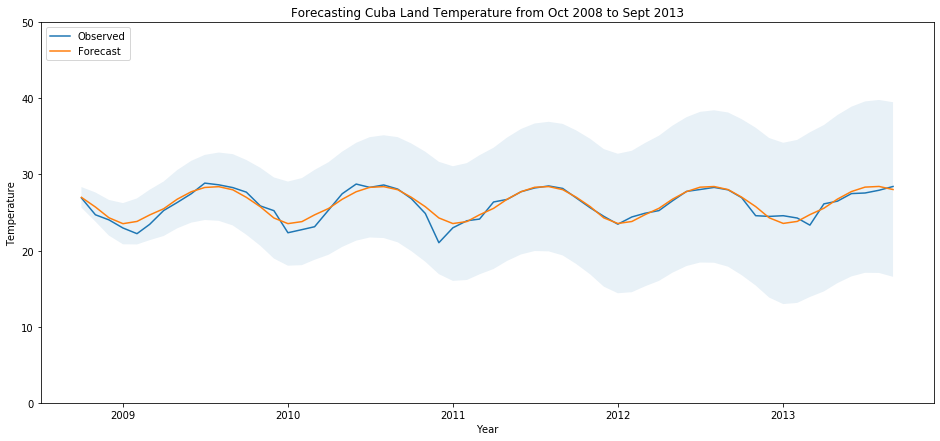

In [33]:
plt.figure(figsize=(16,7))
plt.plot(test_X, test_y, label='Observed')
plt.plot(test_X, pred, label='Forecast')
plt.fill_between(x=test_X, y1=upper_ci, y2=lower_ci, alpha=.1)
plt.legend(loc='upper left')
plt.title('Forecasting Cuba Land Temperature from Oct 2008 to Sept 2013')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.ylim([0,50])
plt.show()

### 3. SARIMAX (1,1,1)(1,1,1)
- ACF and PACF plots have most of the points within 95% confidence interval
- The model fits the data

C:\Users\user\.conda\envs\mimos\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\.conda\envs\mimos\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                 2229
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1917.694
Date:                            Mon, 06 Jul 2020   AIC                           3845.388
Time:                                    23:40:07   BIC                           3873.905
Sample:                                01-01-1823   HQIC                          3855.805
                                     - 09-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3370      0.017     20.341      0.000       0.305       0.370
ma.L1         -0.9820      0.004   

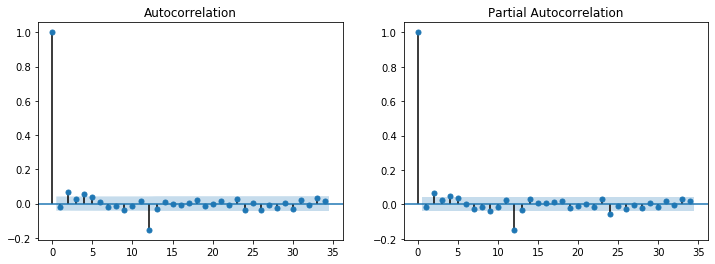

In [25]:
sarima111111 = SARIMAX(train_y, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
print(sarima111111.summary())
sarima111111_res = pd.DataFrame(sarima111111.resid)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(sarima111111_res, ax[0])
plot_pacf(sarima111111_res, ax[1])
plt.show()

In [26]:
sarima111111_prediction = sarima111111.get_forecast(len(test_X))
pred = sarima111111_prediction.predicted_mean
ci = sarima111111_prediction.conf_int().values
lower_ci = [item[0] for item in ci]
upper_ci = [item[1] for item in ci] 

In [27]:
# rmse
rmse = np.sqrt(mse(test_y, pred))
print('rmse: ', rmse)

rmse:  0.7803612409318619


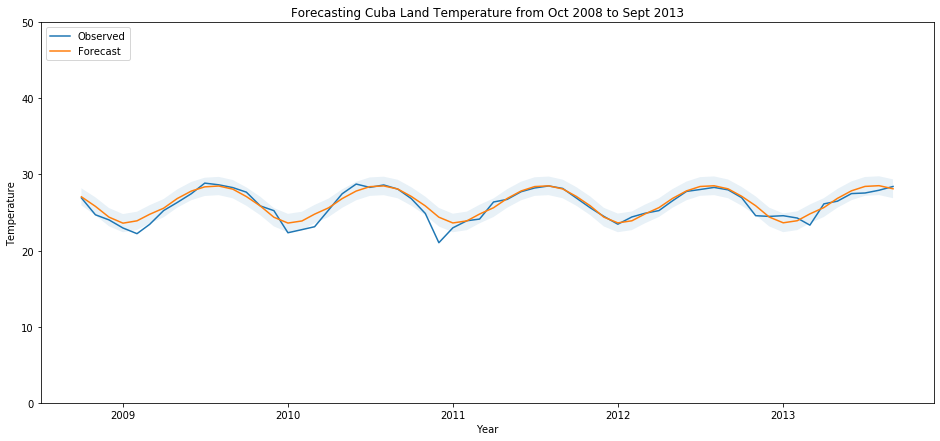

In [29]:
plt.figure(figsize=(16,7))
plt.plot(test_X, test_y, label='Observed')
plt.plot(test_X, pred, label='Forecast')
plt.fill_between(x=test_X, y1=upper_ci, y2=lower_ci, alpha=.1)
plt.legend(loc='upper left')
plt.title('Forecasting Cuba Land Temperature from Oct 2008 to Sept 2013')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.ylim([0,50])
plt.show()

--------------------------------------------------------------------------------------------------------------------
## Conclusion
- Comparison between SARIMAX(0,0,0)(1,1,1,12), SARIMAX(0,1,0)(1,1,1,12) and SARIMAX(1,1,1)(1,1,1,12):
  - AIC: 4209 vs 4688 vs 3845
  - BIC: 4226 vs 4705 vs 3873
  - RMSE: 0.7413 vs 0.7522 vs 0.7804
- By considering the three important criteria (AIC, BIC, RMSE) as shown above, it can be concluded that although the 3rd model has slightly higher RMSE than the other two, but it has much lower AIC and BIC, so the 3rd model should be selected as the best model. 
- In fact, this conclusion is just a prove to the analysis done earlier, whereby plotting residual of the 1st model leads to the hyperparameter setting for the second model and, plotting residual of the 2nd model leads to the hyperparameter setting of the 3rd model. 
- Training stops after the 3rd model is being trained because the residual plot indicates that the model has well fit the data.